In [2]:
import pandas as pd
import numpy as np
markers = './001_trial1_right_log_18-09-46-931825.txt'
fname = './001_trial1_right_OpenBCI-RAW-2020-02-09_17-59-22.txt'
df = pd.read_csv(markers)
start = df['timestamp(ms)'].iloc[0]
end = df['timestamp(ms)'].iloc[-1]
channel = (1,2,3,4,13)
data = np.loadtxt(fname,
                  delimiter=',',
                  skiprows=7,
                  usecols=channel)
eeg = data[:,:-1]
timestamps = data[:,-1]

FileNotFoundError: [Errno 2] File b'./001_trial1_right_log_18-09-46-931825.txt' does not exist: b'./001_trial1_right_log_18-09-46-931825.txt'

In [3]:
import matplotlib.pyplot as plt
for i in eeg.T:
    plt.subplot()
    plt.plot(i)

/home/steve/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [4]:
import datetime
import pytz

def get_ms(str_time):
    """
    Convert timestamp in keyboard markings file to unix milliseconds
    inputs:
      str_time (string)
    outputs:
      milliseconds (float)
    """
    date_time_str = '2020-02-09 ' + str_time
    date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S:%f')

    timezone = pytz.timezone('America/New_York')
    timezone_date_time_obj = timezone.localize(date_time_obj)
    return timezone_date_time_obj.timestamp() * 1000

In [5]:
get_ms(start)

1581289788685.134

In [6]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
SAMPLING_FREQ = 250
def notch_mains_interference(data):
    notch_freq_Hz = np.array([60.0])  # main + harmonic frequencies
    for freq_Hz in np.nditer(notch_freq_Hz):  # loop over each target freq
        bp_stop_Hz = freq_Hz + 3.0 * np.array([-1, 1])  # set the stop band
        b, a = signal.butter(3, bp_stop_Hz / (SAMPLING_FREQ / 2.0), 'bandstop')
        arr = signal.lfilter(b, a, data, axis=0)
        print("Notch filter removing: " +
              str(bp_stop_Hz[0]) +
              "-" +
              str(bp_stop_Hz[1]) +
              " Hz")
    return arr
def filter_signal(arr, lowcut=4.0, highcut=60.0, order=3, notch=True):
    if notch:
        arr = notch_mains_interference(arr)
    nyq = 0.5 * SAMPLING_FREQ
    b, a = signal.butter(1, [lowcut / nyq, highcut / nyq], btype='band')
    for i in range(0, order):
        arr = signal.lfilter(b, a, arr, axis=0)
    return arr
def get_spectral_content(ch, fs_Hz, shift=0.1):
    NFFT = fs_Hz*2
    overlap = NFFT - int(shift * fs_Hz)
    spec_PSDperHz, spec_freqs, spec_t = mlab.specgram(np.squeeze(ch),
                                   NFFT=NFFT,
                                   window=mlab.window_hanning,
                                   Fs=fs_Hz,
                                   noverlap=overlap
                                   ) # returns PSD power per Hz
    # convert the units of the spectral data
    spec_PSDperBin = spec_PSDperHz * fs_Hz / float(NFFT) 
    return spec_t, spec_freqs, spec_PSDperBin  # dB re: 1 uV

def plot_specgram(spec_freqs, spec_PSDperBin,title,shift,i=1):
    f_lim_Hz = [0, 30]   # frequency limits for plotting
    #plt.figure(figsize=(10,5))
    spec_t = [idx*.1 for idx in range(len(spec_PSDperBin[0]))]
    plt.subplot(3,1,i)
    plt.title(title)
    plt.pcolor(spec_t, spec_freqs, 10*np.log10(spec_PSDperBin))  # dB re: 1 uV
    plt.clim([-25,26])
    plt.xlim(spec_t[0], spec_t[-1]+1)
    plt.ylim(f_lim_Hz)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.subplots_adjust(hspace=1)

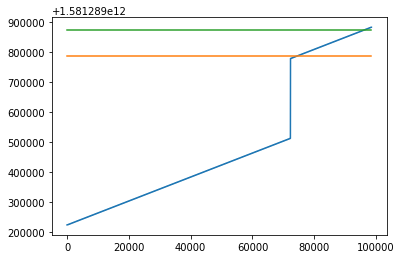

In [7]:
import matplotlib.pyplot as plt

plt.plot(timestamps)
plt.plot([0,len(timestamps)], [get_ms(start), get_ms(start)])
plt.plot([0,len(timestamps)], [get_ms(end), get_ms(end)])

In [8]:
start_idx = np.where(timestamps > get_ms(start))[0][0]
end_idx = np.where(timestamps > get_ms(end))[0][0]

In [9]:
markings = [get_ms(val) for val in df['timestamp(ms)'].values[::2]]
labels = df.values[:,1]

markings

[1581289788685.134,
 1581289790589.497,
 1581289794730.437,
 1581289796748.03,
 1581289800321.475,
 1581289802887.906,
 1581289805565.223,
 1581289808472.9568,
 1581289811799.043,
 1581289814631.221,
 1581289817901.8062,
 1581289820921.945,
 1581289823665.126,
 1581289826641.9922,
 1581289829662.606,
 1581289832949.344,
 1581289835824.1191,
 1581289838560.543,
 1581289842426.2559,
 1581289844819.294,
 1581289847713.781,
 1581289850928.62,
 1581289853599.979,
 1581289856622.671,
 1581289859598.192,
 1581289862736.606,
 1581289865577.296,
 1581289868630.87,
 1581289871685.776,
 1581289874959.2942]

Notch filter removing: 57.0-63.0 Hz
Notch filter removing: 57.0-63.0 Hz
Notch filter removing: 57.0-63.0 Hz
Notch filter removing: 57.0-63.0 Hz


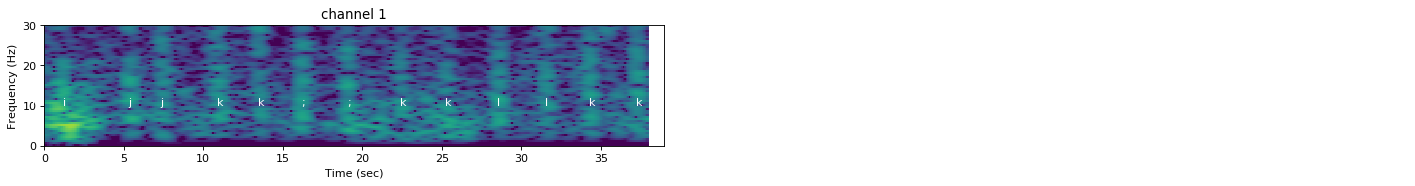

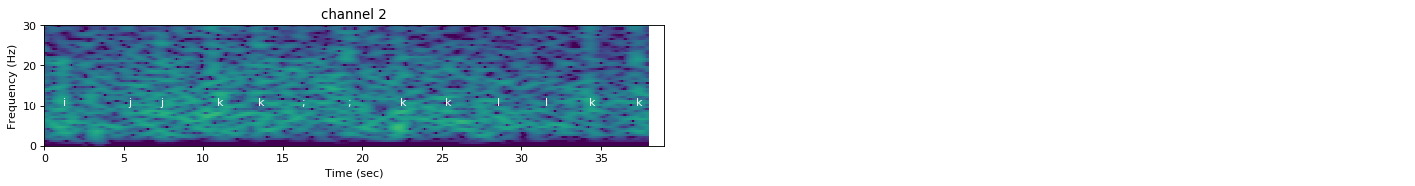

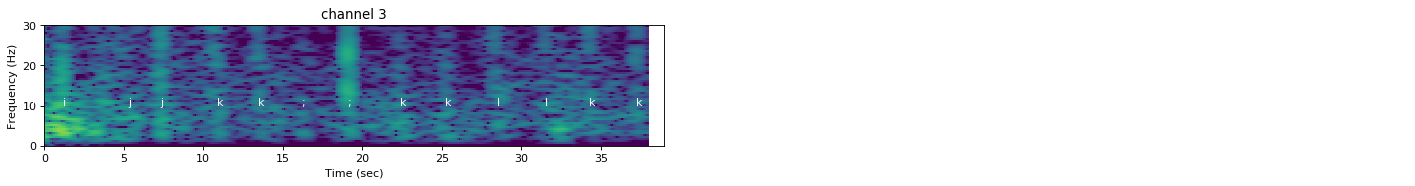

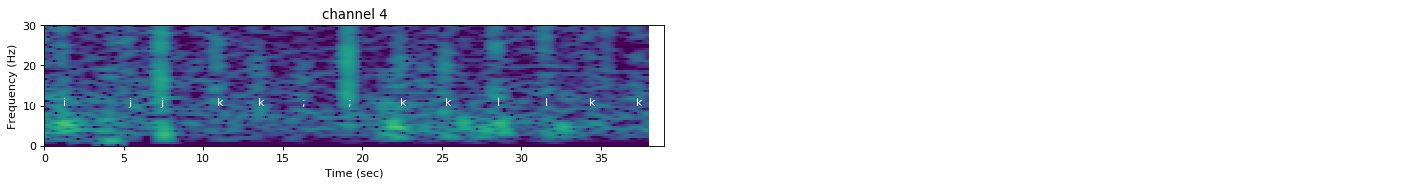

In [10]:
for idx, ch in enumerate(eeg.T):
    ch = filter_signal(ch)
    t, spec_freqs, spec_PSDperBin = get_spectral_content(ch[start_idx:start_idx + 10000], 250)
    fig=plt.figure(figsize=(10,10), dpi= 80, facecolor='w', edgecolor='k')
    plot_specgram(spec_freqs, spec_PSDperBin,'channel {}'.format(idx + 1), 0)
    for mark, label in zip(markings, labels):
        plt.text((mark - get_ms(start)-750)/1000,10,label, color='white')
# for mark, label in zip(markings, labels):
#   plt.axvline((mark - get_ms(start))/1000, color='white')
#   plt.text((mark - get_ms(start))/1000,10,label, color='white')

Notch filter removing: 57.0-63.0 Hz
Notch filter removing: 57.0-63.0 Hz
Notch filter removing: 57.0-63.0 Hz
Notch filter removing: 57.0-63.0 Hz


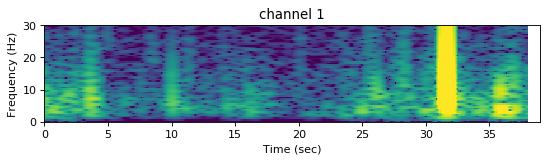

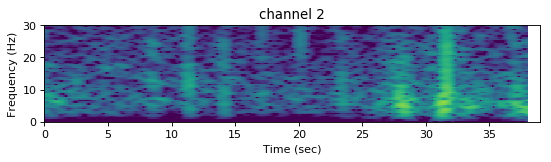

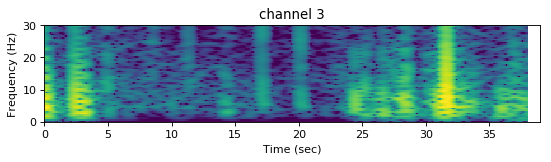

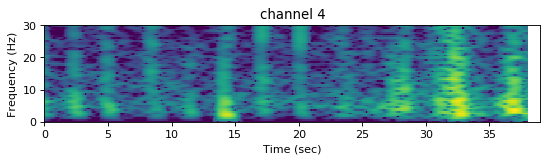

In [11]:
for idx, ch in enumerate(eeg.T):
    ch = filter_signal(ch)
    t, spec_freqs, spec_PSDperBin = get_spectral_content(ch[20000:30000], 250)
    fig=plt.figure(figsize=(8,8), dpi= 80, facecolor='w', edgecolor='k')
    plot_specgram(spec_freqs, spec_PSDperBin,'channel {}'.format(idx + 1), 0)
# for mark, label in zip(markings, labels):
#   plt.axvline((mark - get_ms(start))/1000, color='white')
#   plt.text((mark - get_ms(start))/1000,10,label, color='white')

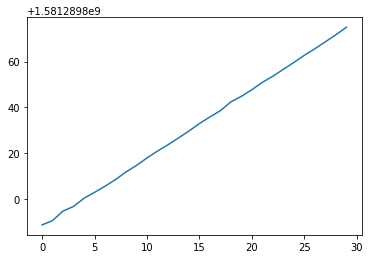

In [12]:
plt.plot([m/1000 for m in markings])

In [51]:
for i in zip([1,2],[3,4]):
    print(i)

(1, 3)
(2, 4)
